In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [25]:
import torch
import scipy.io
import scipy.sparse as sp
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import kneighbors_graph
import torch.nn as nn
import torch.nn.functional as F
from sklearn.metrics import (
    confusion_matrix, f1_score, recall_score, cohen_kappa_score,
    accuracy_score, classification_report
)


class GCNLayer(nn.Module):
    def __init__(self, in_features, out_features):
        super().__init__()
        self.linear = nn.Linear(in_features, out_features)

    def forward(self, x, adj):
        return self.linear(torch.sparse.mm(adj, x))

class GCN(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, dropout=0.5):
        super().__init__()
        self.gcn1 = GCNLayer(input_dim, hidden_dim)
        self.gcn2 = GCNLayer(hidden_dim, output_dim)
        self.dropout = dropout

    def forward(self, x, adj):
        x = F.relu(self.gcn1(x, adj))
        x = F.dropout(x, self.dropout, self.training)
        x = self.gcn2(x, adj)
        return x

# Define normalize_adj function
def normalize_adj(adj):
    adj = sp.coo_matrix(adj)
    rowsum = np.array(adj.sum(1)).flatten()
    d_inv_sqrt = np.power(rowsum, -0.5)
    d_inv_sqrt[np.isinf(d_inv_sqrt)] = 0.
    D_inv = sp.diags(d_inv_sqrt)
    return D_inv @ adj @ D_inv


# Load the saved model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = GCN(input_dim=200, hidden_dim=128, output_dim=16)  # Assuming these are your model parameters
model.load_state_dict(torch.load('/content/drive/MyDrive/best_gcn_model.pth'))
model.to(device)
model.eval()  # Set the model to evaluation mode

# Load the dataset
data = scipy.io.loadmat("/content/drive/MyDrive/Indian_pines_corrected.mat")['indian_pines_corrected']
labels = scipy.io.loadmat("/content/drive/MyDrive/Indian_pines_gt.mat")['indian_pines_gt']

# Preprocess the data (similar to your training data preprocessing)
H, W, C = data.shape
X = data.reshape(-1, C)
y = labels.flatten()
scaler = StandardScaler()
X = scaler.fit_transform(X)
coords = np.array([[i // W, i % W] for i in range(H * W)])
adj = kneighbors_graph(coords, n_neighbors=8, include_self=True)
adj = normalize_adj(adj)  # Assuming you have the normalize_adj function defined
adj = adj.tocoo()
adj = torch.sparse_coo_tensor(
    torch.LongTensor(np.vstack((adj.row, adj.col))),
    torch.FloatTensor(adj.data),
    torch.Size(adj.shape)
).to(device)

features = torch.FloatTensor(X).to(device)
labels_full = torch.LongTensor(y - 1).to(device)  # Adjust labels to 0-indexed

# Create test mask (replace with your desired logic for selecting test data)
# Example: Selecting data points with label > 0
mask = y > 0
test_mask = torch.zeros(H * W, dtype=torch.bool).to(device)
test_mask[mask] = True

# Make predictions on the test data
with torch.no_grad():
    logits = model(features, adj)
    preds = logits[test_mask].argmax(dim=1).cpu().numpy()
    true_labels = labels_full[test_mask].cpu().numpy()

# Evaluate the predictions (e.g., calculate accuracy, confusion matrix, etc.)
# ...

In [17]:
import pickle

with open('/content/drive/MyDrive/model_classes.pkl', 'rb') as f:
    GCNLayer, GCN, normalize_adj = pickle.load(f)

#Now create your model instance using loaded classes
model = GCN(input_dim=200, hidden_dim=128, output_dim=16)
model.load_state_dict(torch.load('/content/drive/MyDrive/best_gcn_model (1).pth'))

<All keys matched successfully>

In [26]:
model.eval()

GCN(
  (gcn1): GCNLayer(
    (linear): Linear(in_features=200, out_features=128, bias=True)
  )
  (gcn2): GCNLayer(
    (linear): Linear(in_features=128, out_features=16, bias=True)
  )
)

In [18]:
# ipython-input-61-ba8d9e8bf402

# Use the true_labels and preds generated in the same cell (cell 60)
conf_mat = confusion_matrix(true_labels, preds)
per_class_acc = conf_mat.diagonal() / conf_mat.sum(axis=1)
class_report = classification_report(true_labels, preds, output_dict=True)
f1 = f1_score(true_labels, preds, average='weighted')
recall = recall_score(true_labels, preds, average='weighted')
kappa = cohen_kappa_score(true_labels, preds)
oa = accuracy_score(true_labels, preds)
aa = per_class_acc.mean()

In [19]:
print("\nClass-wise Accuracy:")
for i, acc in enumerate(per_class_acc):
    print(f"Class {i+1}: {acc*100:.2f}%")


Class-wise Accuracy:
Class 1: 95.65%
Class 2: 95.66%
Class 3: 95.54%
Class 4: 93.25%
Class 5: 98.76%
Class 6: 99.45%
Class 7: 100.00%
Class 8: 100.00%
Class 9: 95.00%
Class 10: 92.90%
Class 11: 98.53%
Class 12: 97.47%
Class 13: 100.00%
Class 14: 99.37%
Class 15: 95.08%
Class 16: 98.92%


In [20]:
print("\nFinal Metrics:")
print(f"OA: {oa*100:.2f}% | AA: {aa*100:.2f}% | F1: {f1:.4f} | Recall: {recall:.4f} | Kappa: {kappa:.4f}")


Final Metrics:
OA: 97.31% | AA: 97.22% | F1: 0.9730 | Recall: 0.9731 | Kappa: 0.9693


In [21]:
import seaborn as sns
import matplotlib.pyplot as plt

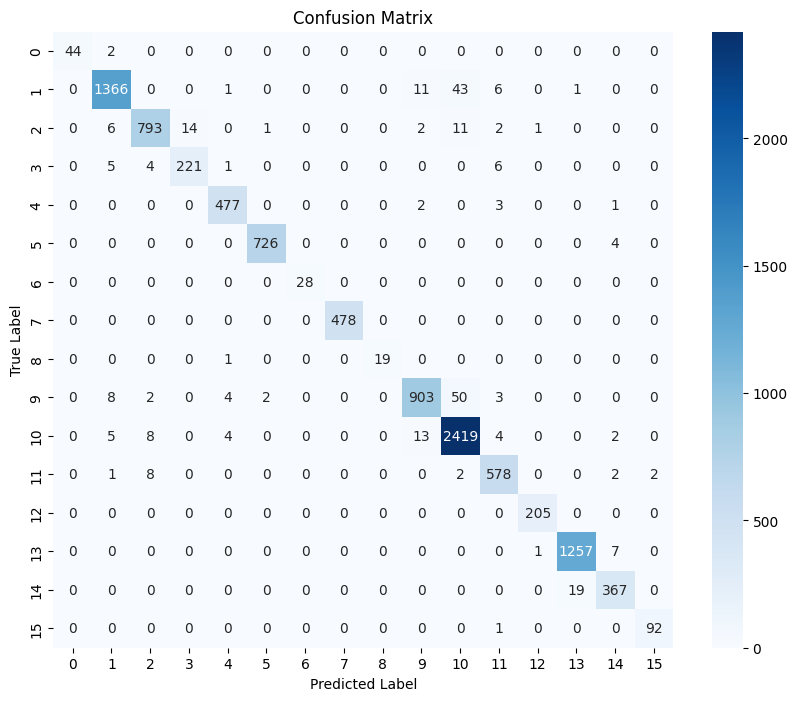

In [22]:
plt.figure(figsize=(10, 8))  # Adjust figure size if needed
sns.heatmap(conf_mat, annot=True, fmt="d", cmap="Blues")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

In [ ]:
!pip install openpyxl

In [23]:
import openpyxl

# ... (your existing code) ...

print("\nClass-wise Accuracy:")
class_accuracies = []  # List to store class accuracies
for i, acc in enumerate(per_class_acc):
    class_acc_str = f"Class {i+1}: {acc*100:.2f}%"
    print(class_acc_str)
    class_accuracies.append([i+1, None, f"{acc*100:.2f}"])  # Add None for blank column

# Create a new workbook and worksheet
workbook = openpyxl.Workbook()
worksheet = workbook.active
worksheet.title = "Class-wise Accuracy"

# Add header row
worksheet.append(["Class", "", "Accuracy (%)"])  # Add blank header for the empty column

# Add class accuracies to the worksheet
for row in class_accuracies:
    worksheet.append(row)

# Save the workbook
workbook.save("class_wise_accuracy.xlsx")
print("\nClass-wise accuracy saved to class_wise_accuracy.xlsx")


Class-wise Accuracy:
Class 1: 95.65%
Class 2: 95.66%
Class 3: 95.54%
Class 4: 93.25%
Class 5: 98.76%
Class 6: 99.45%
Class 7: 100.00%
Class 8: 100.00%
Class 9: 95.00%
Class 10: 92.90%
Class 11: 98.53%
Class 12: 97.47%
Class 13: 100.00%
Class 14: 99.37%
Class 15: 95.08%
Class 16: 98.92%

Class-wise accuracy saved to class_wise_accuracy.xlsx


In [24]:
model.eval()

GCN(
  (gcn1): GCNLayer(
    (linear): Linear(in_features=200, out_features=128, bias=True)
  )
  (gcn2): GCNLayer(
    (linear): Linear(in_features=128, out_features=16, bias=True)
  )
)